# 3.1 Vectorizing & Naïve Bayes Models

# Problem Statement: Given a post from either r/travel or r/solotravel, how well can we predict from which subreddit it came?

#### Baseline accuracy is exactly 50% because we have exactly 20,000 rows from each subreddit

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import time

np.random.seed(42)

In [2]:
df = pd.read_csv('./cleaned_data')
# dropping new rows with null selftext values
df.drop(df.loc[df['selftext'].isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

X = df['selftext']
y = df['solotravel']

tvec = TfidfVectorizer()
tvec.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_train_transformed = tvec.transform(X_train)
X_test_transformed = tvec.transform(X_test)

In [3]:
def scores(model):
    print(f'train score: {model.score(X_train_transformed, y_train)}')
    print(f'test score: {model.score(X_test_transformed, y_test)}')
    print()
    
    try:
        print(f'best score: {model.best_score_}')
        print(f'best params: {model.best_params_}')
    except:
        pass

### Basic CountVectorizer BernoulliNB model

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    stratify=y,
                                                    random_state=42)

In [5]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', BernoulliNB())
])

In [6]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', BernoulliNB())])

In [7]:
pipe.score(X_train, y_train)

0.6797636909227307

In [8]:
pipe.score(X_test, y_test)

0.6557889472368092

Our training and testing scores aren't too far off from one another so our variance is pretty low. But we only have at 15% accuracy increase over our null model. So there's still much improvement to be made

### GridSearch over CountVectorizer BernoulliNB model

In [9]:
# resetting train_test_split values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
pipe_params = {
    'cvec__max_features':[2_000, 3_000, 4_000, 5_000], 
    'cvec__min_df'      :[2, 3], 
    'cvec__max_df'      :[0.9, 0.95], 
    'cvec__ngram_range' :[(1,1), (1,2)]
}

In [11]:
gs = GridSearchCV(pipe, pipe_params, cv=5, verbose=1)

In [12]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 11min, sys: 18.3 s, total: 11min 18s
Wall time: 11min 20s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [14]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.6835146286571643
0.6765441360340085


The scores with these parameters still haven't improved much.

In [15]:
preds = gs.predict(X_test)

cm = confusion_matrix(y_test, preds)

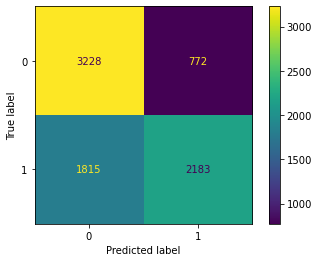

In [16]:
ConfusionMatrixDisplay(cm).plot();

#### Not a very impressive model - less than 70% accuracy

# Changing the parameters a bit

In [17]:
pipe_params = {
    'cvec__max_features':[10_000, 20_000, 30_000], 
    'cvec__min_df'      :[10], 
    'cvec__max_df'      :[0.9], 
    'cvec__ngram_range' :[(2,3),(3,4),(2,4)]
}

In [18]:
gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1, verbose=1)

In [19]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 16.8 s, sys: 3.08 s, total: 19.9 s
Wall time: 8min 7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [10000, 20000, 30000],
                         'cvec__min_df': [10],
                         'cvec__ngram_range': [(2, 3), (3, 4), (2, 4)]},
             verbose=1)

In [20]:
print(gs.best_score_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.6859211600202653
0.735527631907977
0.6935483870967742


Even worse

### Let's try with a TF-IDF Vectorizer (and a Multinomial Naïve Bayes)

In [21]:
# resetting train_test_split values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    stratify=y,
                                                    random_state=42)

In [22]:
tvec = TfidfVectorizer()

In [23]:
%%time
X_train_df = pd.DataFrame(
    tvec.fit_transform(X_train).todense(), 
    columns = tvec.get_feature_names()
)

CPU times: user 2.78 s, sys: 1.42 s, total: 4.2 s
Wall time: 4.31 s


In [24]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB()) #changed this for a better model
])

In [25]:
pipe_params = {
    'tvec__max_features':[2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range' :[(1,1), (1,2), (2,2), (2,3)]
}

In [26]:
gs_tvec = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, verbose=1)

In [27]:
%%time
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 10 s, sys: 2.05 s, total: 12.1 s
Wall time: 4min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             verbose=1)

In [31]:
print(gs_tvec.best_score_)
print(gs_tvec.score(X_train, y_train))
print(gs_tvec.score(X_test, y_test))

0.7435920478548516
0.7628782195548888
0.7414353588397099


This is a noticably better score (by about 10%) and it still keeps the training and testing scores close to each other.

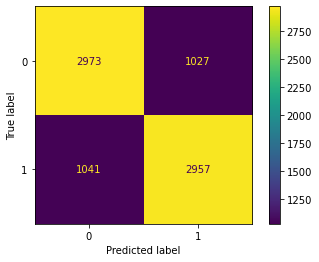

In [29]:
preds_gs_test = gs_tvec.predict(X_test)

cm = confusion_matrix(y_test, preds_gs_test)
ConfusionMatrixDisplay(cm).plot();

Here we can see our accuracy improving but we still have about 2000 of the 8000 results misclassified.